# 04. Pytorch Custom Datasets Video NoteBook

We've used some datasets with Pytorch before

But hw do you get your own data into Pytorch 

One of the ways to do is via: custom datasets

## Domain libraries
Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the Pytorch domain libraries for existing data loading functions and customizable data loading functions

## 0. Importing Pytorch and Setting up device-agnostic code

In [1]:
import torch
from torch import nn


In [2]:
# Setup Device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Sat Jan 11 22:07:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.07                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P0             16W /  134W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

Our dataset is a subset of the Food 101 dataset.

Food 101 starts 101 different classes of food & 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (75 training, 25 testing)

Why do this? When starting out ML projects, it's important to try things on a small scale & then increase the scale when necessary

The whole point is to speed up hw fast u can experiment



In [4]:
import requests
import zipfile

from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# Create the directory
image_path.mkdir(parents=True, exist_ok=True)

# Download dataset 
with open(data_path / 'pizza_steak_sushi.zip','wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    f.write(request.content)
    
# Unzip pizza
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Unzipping pizza, steak, sushi data...


## 2. Becoming One with the Data (data preparation and data extraction)

In [5]:
import os
def walk_thr_dir(dir_path):
    ''' Walk thr dir path returning its content'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There're {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [6]:
walk_thr_dir(image_path)

There're 2 directories and 0 images in data\pizza_steak_sushi
There're 3 directories and 0 images in data\pizza_steak_sushi\test
There're 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There're 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There're 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There're 3 directories and 0 images in data\pizza_steak_sushi\train
There're 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There're 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There're 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [7]:
# Setup train and testing paths 
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing n Image

1. Get all of the image paths
2. Pick a random image path using Python random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python PIL
5. We'll then show the image and print metadata

Random image path: data\pizza_steak_sushi\train\sushi\268990.jpg
Image class: sushi
Image Height: 512
Image Width: 384


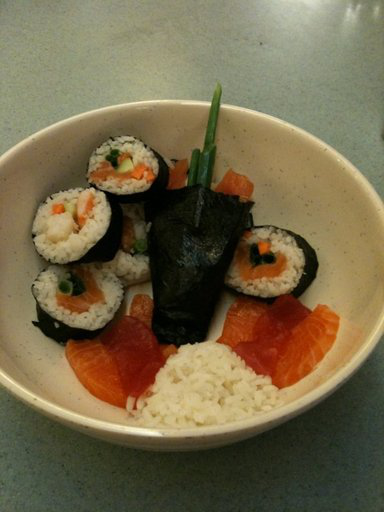

In [8]:
import random
from PIL import Image

# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class fr path name (the image class is the name of directory where the image is store)
image_class = random_image_path.parent.stem


# 4. Open image
img = Image.open(random_image_path)

# 5. Print Metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(-0.5, 383.5, 511.5, -0.5)

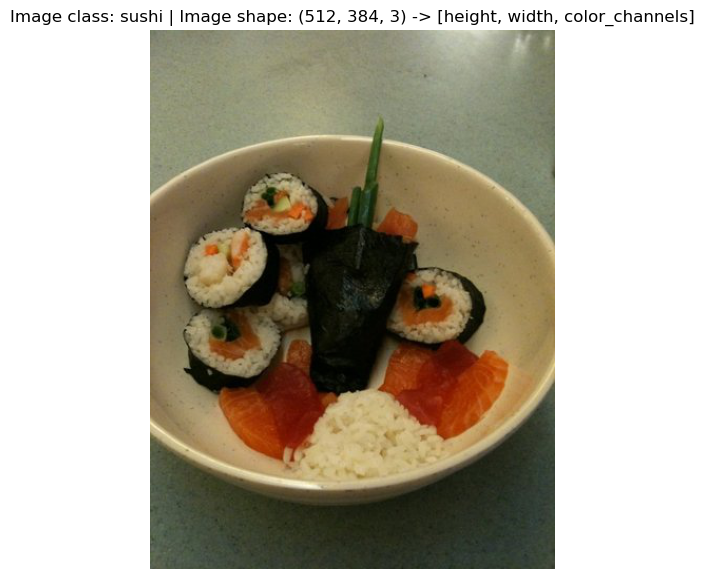

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image -> array
img_as_array = np.array(img)

# Plot the image into an array
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## 3. Transforming data

Before we can use our imgae data with Pytorch:
1. Turn your target data into tensors (numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

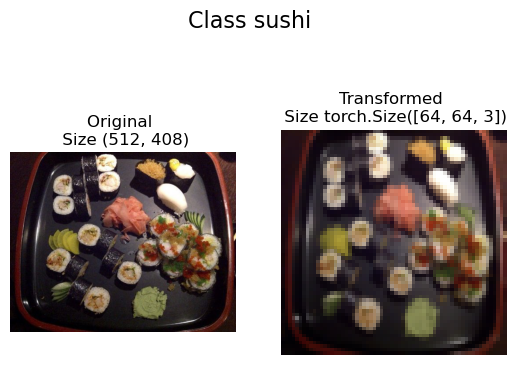

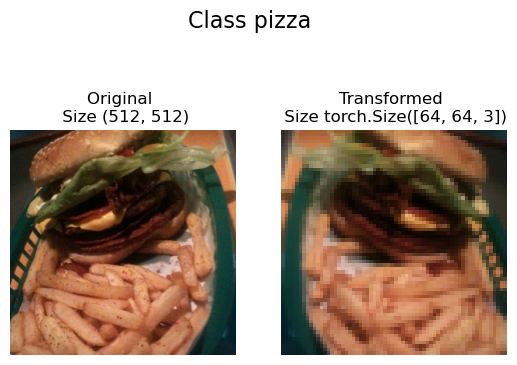

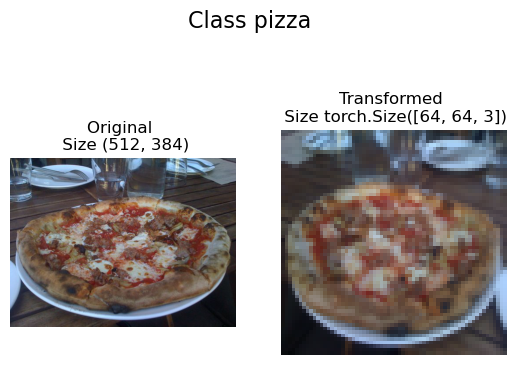

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    '''
    Plot a series of random images from image_path
    
    Will open n image paths from image_paths, transform them
    will transform and plot them side by side
    
    Args:
        image_paths (list): list of target image paths
        transform (Pytorch transform): transforms to apply to images
        n (int, optional): number of images to plot. Default to 3
        seed (int, optional): Random seed for the random generator. Default to 42
    
    ''' 
    random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \n Size {f.size}")
            ax[0].axis("off")
            
            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (Pytorch default is [c,h,w] but matplotlib is [h,w,c])
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \n Size {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class {image_path.parent.stem}", fontsize=16)
            
plot_transformed_images(image_path_list,transform=data_transform, n=3)

## 4. Option 1: Loading Image `ImageFolders`

We can load image classification data using `torchvision.datasets.ImageFolders` 

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # a transform for the data
                                  )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Index on the train dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img

tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0902, 0.0902, 0.

In [17]:
class_names[label]

'pizza'

In [18]:
img.shape

torch.Size([3, 64, 64])

Original shape: torch.Size([3, 64, 64]) [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) [ height, width, color_channels]


Text(0.5, 1.0, 'pizza')

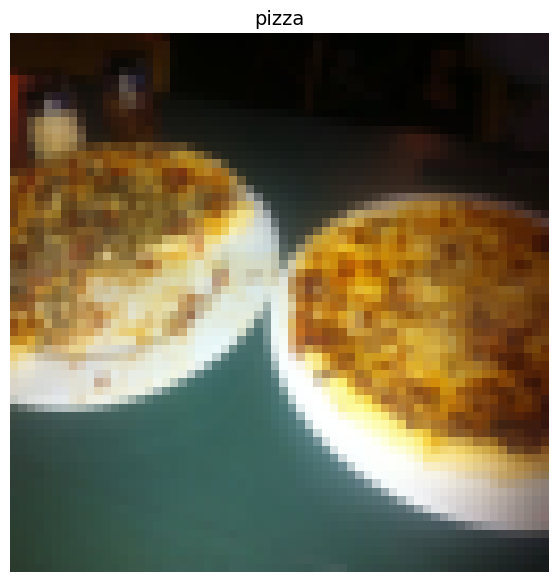

In [19]:
# Rearrange the oder dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} [ height, width, color_channels]")

# Plot the image 
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset` -> iterables and we can customize the batch_size so our model can see `batch_size` images at a time


In [20]:
import os 
os.cpu_count()

20

In [21]:
# Turn train and set datasets into DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 32 
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(),shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f6a5e57460>,
 <torch.utils.data.dataloader.DataLoader at 0x1f6a2c316d0>)

In [22]:
img, label = next(iter(train_dataloader))

## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file 
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros: 
* Can create a `Dataset` out of almost anything
* Not limited to Pytorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work ...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues 

In [23]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List



In [24]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target dir (ideally the dic is in standard image class format)
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with this dir structure)
3. Turn the class names into a dict and a list return them




In [25]:
train_dir

WindowsPath('data/pizza_steak_sushi/train')

In [26]:
# Setup path for target dir 
target_dir = train_dir
print(f"Target dir: {target_dir} ")

# Get the class names from the target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])

class_names_found

Target dir: data\pizza_steak_sushi\train 


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    # Find the class folder names in a target dir
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # Raise an error if class names couldn't be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}... please check file structure")
    # Create a dir of index labels (computer prefer numbers rather than strings as label)
    class_to_idx ={cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [28]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target dir (the dir we'd like to get data from) as well as transform if we'd like to transform our data
3. Create several attributes:
* paths - paths of our images
* transform - the transform we'd like to use
* classes - a list of target classes
* class_to_idx - a dict of target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [29]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Datset
class ImageFolderCustom(Dataset):
    # 2. Initialize our dataset
    def __init__(self, targ_dir: str, transform=None):
        # 3. Create class attributes
        # Get all of image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Create classes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    # 4. Create a function to load image
    def load_image(self, index: int ) -> Image.Image:
        # Opens an image via a path and returns it 
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len()__
    def __len__(self) ->int:
        # Return the total number of samples
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        # Return one sample of data n label (X,Y)
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_names/image.jpg
        class_idx = self.class_to_idx[class_name]
        
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # Return untransformed image and label

In [30]:
# Create a transform 
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [31]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transform)

In [32]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1f6a5e4b640>,
 <__main__.ImageFolderCustom at 0x1f6a6220ee0>)

In [33]:
# Check for equality btw orginal ImageFoler Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)

True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and hw many images to visualize 
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility 
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop thr the random sample images and plot them with matplotlib
7. Make sure the dimension of our images line up with matplotlib (HWC)

In [34]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset, classes: List[str]= None, n: int = 10, display_shape: bool = True, seed: int = None):
    # 2. Adjust display if n is to high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
        
    # 3. Set the seed
    if seed:
        random.seed(seed)
        
    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)),k=n)
    
    # 5. Set up plot
    plt.figure(figsize=(16,8))
    
    
    # 6. Loop thr random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0)
        # plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\n shape: {targ_image_adjust.shape}"
        plt.title(title)

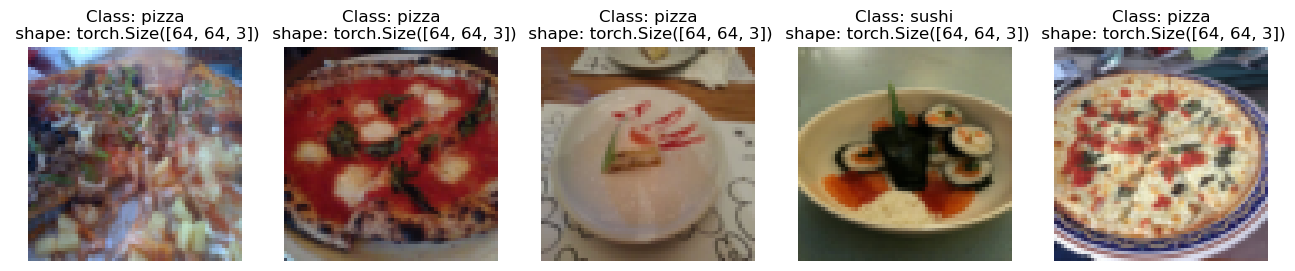

In [35]:
# Display random images from the ImageFolder, created Dataset
display_random_images(train_data, n=5, classes=class_names, seed=None)

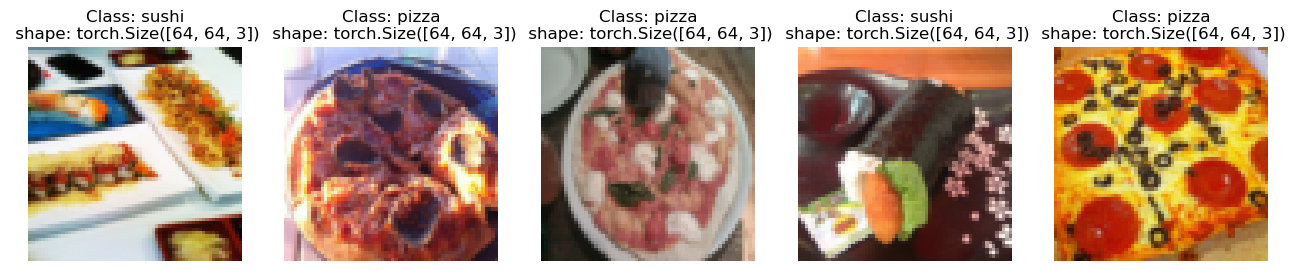

In [36]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom, n=5, classes=class_names, seed=42)

### 5.4 Turn custom loaded images into `DataLoader`

In [37]:
from torch.utils.data import DataLoader

# BATCH_SIZE = 32
# NUM_WORKERS = os.cpu_count()
train_data_loader_custom = DataLoader(dataset=train_data_custom, batch_size=1, num_workers=0, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=1, num_workers=0, shuffle=False)

train_data_loader_custom, test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x1f6a5dd9580>,
 <torch.utils.data.dataloader.DataLoader at 0x1f6a5cdc040>)

In [38]:
# Get image and label from custom dataloader 
img_custom, label_custom = next(iter(train_data_loader_custom))

img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (Data augmentation)

Data augmentation is the process of artificially adding diversity to your training dataset

In case of image data, this may mean applying various image transformations to the training images

This practice hopefully results in a model that's more generalizable to unseen data

Let's take a look at one particular type of data augmentation used to train Pytorch vision models to state of the art levels...



In [39]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [40]:
# Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

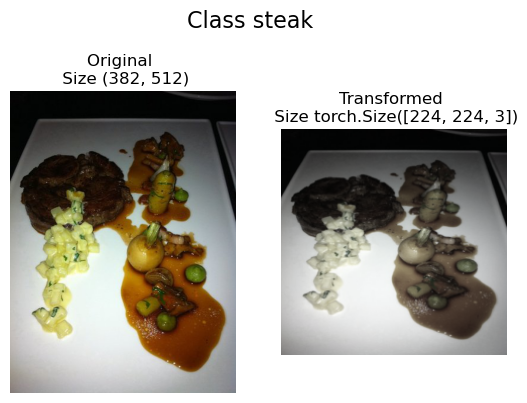

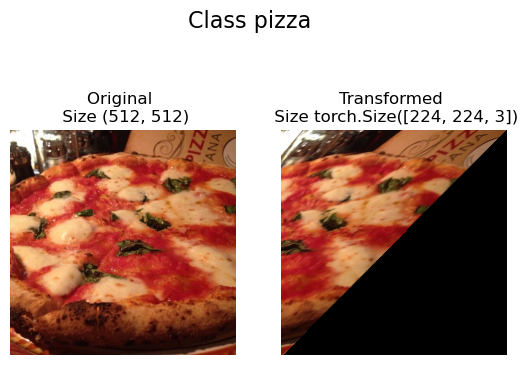

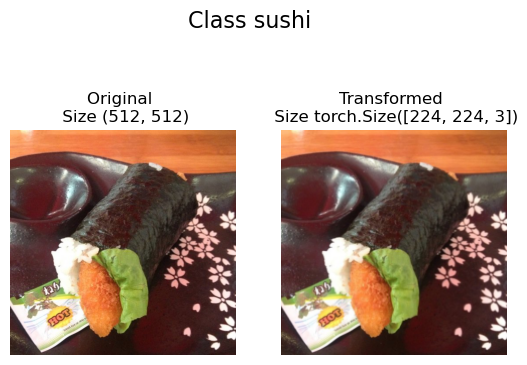

In [41]:
# plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: Tiny VGG without Data Augmentation

Let's replicate Tiny VGG architecture from CNN explainer 

### 7.1 Creating transforms and Loading data Model 0

In [42]:
# create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [43]:
# 1. Load & Transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn datasets into Dataloaders
# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


## 7.2 Create Tiny VGG Model class

In [47]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Default stride value is same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Default stride value is same as kernel size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [48]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the mode)


In [49]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
# Try a forward pass 

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [54]:
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions 

* `train_step()` - takes in a model & dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on dataloader



In [55]:
# Create train_step()
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0,0
    
    # Loop thr data loader data batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate accuracy metrics
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    # Adjust metrics to get average loss n accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [56]:
# Create a test step
import torch.utils


def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device=device):
    # Put model in eval mode
    model.eval()
    
    # Setup test loss n test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference mode
    with torch.inference_mode():
        # Loop thr DataLoader batches
        for batch, (X, y) in enumerate(dataloader): 
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)
        
            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate accuracy metrics
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels) )
    # Adjust metrics to get average loss n accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
            
            

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [76]:
from tqdm.auto import tqdm 
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    # Create empty results dic
    results = { 
        'train_loss':[],
        'train_acc':[],
        'test_loss':[],
        'test_acc':[],
    }
    
    # Loop thr training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader, 
                                        loss_fn=loss_fn)
    
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")
        # Update results dic
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

### 7.7 Train & Evaluate Model 0

In [78]:
device

'cuda'

In [77]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


 20%|██        | 1/5 [00:14<00:59, 14.77s/it]

Epoch: 0 | Train loss: 1.1078 | Train acc: 0.2578 | Test acc: 0.2604
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


 40%|████      | 2/5 [00:30<00:45, 15.26s/it]

Epoch: 1 | Train loss: 1.0847 | Train acc: 0.4258 | Test acc: 0.1979
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


 60%|██████    | 3/5 [00:45<00:30, 15.11s/it]

Epoch: 2 | Train loss: 1.1157 | Train acc: 0.2930 | Test acc: 0.1979
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


 80%|████████  | 4/5 [00:59<00:14, 14.64s/it]

Epoch: 3 | Train loss: 1.0955 | Train acc: 0.4141 | Test acc: 0.1979
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


100%|██████████| 5/5 [01:12<00:00, 14.55s/it]

Epoch: 4 | Train loss: 1.0984 | Train acc: 0.2930 | Test acc: 0.1979
Total training time: 72.746 seconds


### 7.8 Plot the curves of Model

A **Loss Curve** is a way of tracking your model's progress over time


In [79]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

![Alt text](https://camo.githubusercontent.com/663db431acbebd080570a6bb9e0750f7d4a1966a11b5c1f4abac946370981211/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f7079746f7263682d646565702d6c6561726e696e672f6d61696e2f696d616765732f30342d6c6f73732d6375727665732d6f76657266697474696e672d756e64657266697474696e672d696465616c2e6a7067)

In [80]:
def plot_loss_curves(results: Dict[str, List[float]]):
    '''
    Plots training curves of a results dic 
    '''
    # Get the loss values of the results dic (training & set)
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    # Get the accuracy values of the results dic (training and testing)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    # Figure out hw many epochs there were
    epochs = range(len(results['train_loss']))
    
    # Setup a plot
    plt.figure(figsize=(15,7))    
    
    # Plot the loss
    plt.subplot(1, 2,1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


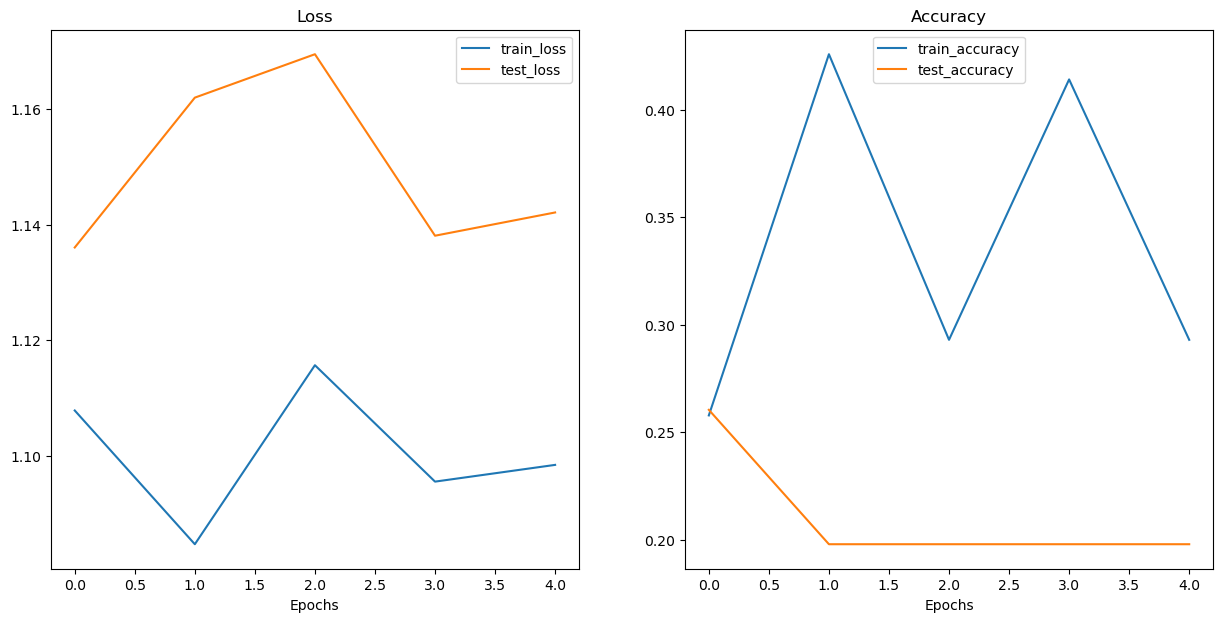

In [81]:
plot_loss_curves(model_0_results)

## Model 1: TinyVGG with Data Augmentation 

### Create transform with data augmentation


In [83]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### Create train & test Dataset and DataLoader with data augmentation


In [84]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transform_simple)


In [85]:
# Turn our Datasets into DataLoaders 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

train_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)


### Construct and Train Model 1

This time we'll be using the same model architecture except this time, we've augmented the training data


In [86]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Now let's create a loss function and an optimizer and call upon our `train()` function to train and evaluate our model

In [93]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

# Train model 1
model_1_results = train(model=model_1, train_dataloader=train_dataloader_augmented, test_dataloader=test_dataloader_simple,
                        optimizer=optimizer, 
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        )

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


 20%|██        | 1/5 [00:19<01:17, 19.49s/it]

Epoch: 0 | Train loss: 0.9582 | Train acc: 0.4648 | Test acc: 0.3722
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


 40%|████      | 2/5 [00:34<00:50, 16.71s/it]

Epoch: 1 | Train loss: 0.8602 | Train acc: 0.5977 | Test acc: 0.3428
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


 60%|██████    | 3/5 [00:48<00:31, 15.67s/it]

Epoch: 2 | Train loss: 0.8694 | Train acc: 0.6016 | Test acc: 0.3939
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


 80%|████████  | 4/5 [01:02<00:15, 15.08s/it]

Epoch: 3 | Train loss: 0.8064 | Train acc: 0.6250 | Test acc: 0.4034
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([32, 10, 32, 32])
torch.Size([32, 10, 16, 16])
torch.Size([32, 3])
torch.Size([11, 10, 32, 32])
torch.Size([11, 10, 16, 16])
torch.Size([11, 3])


100%|██████████| 5/5 [01:18<00:00, 15.79s/it]

Epoch: 4 | Train loss: 0.8127 | Train acc: 0.6445 | Test acc: 0.3930
Total training time: 78.943 seconds


### Plot the loss of model 1

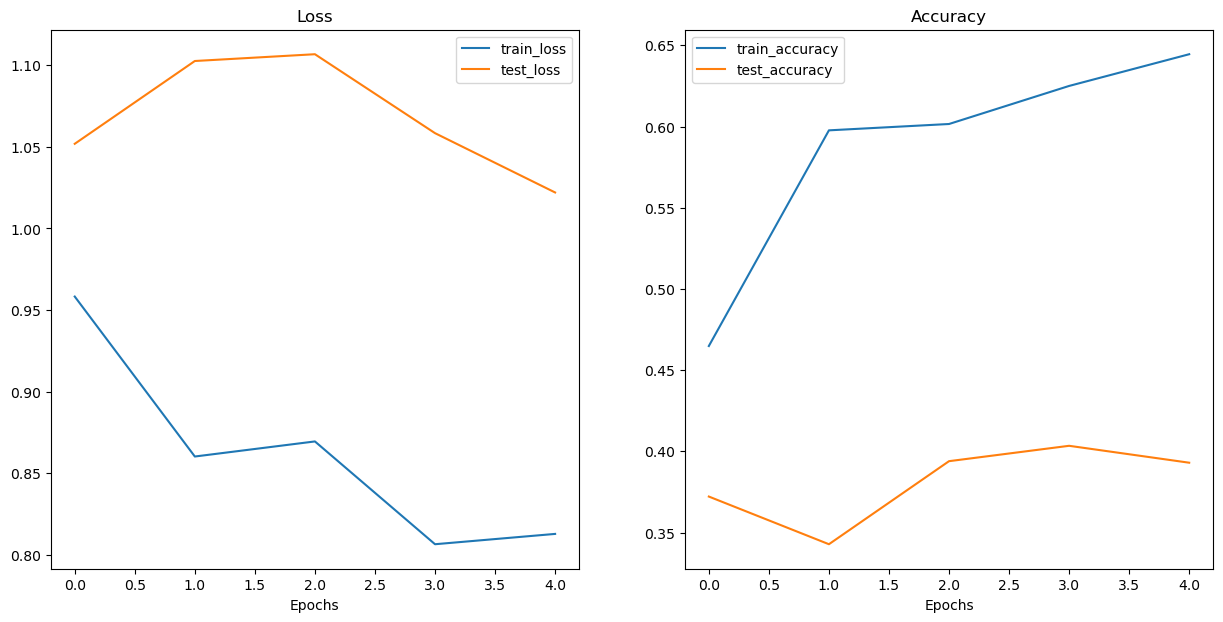

In [94]:
plot_loss_curves(model_1_results)

## 10. Compare Model Results

In [95]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)



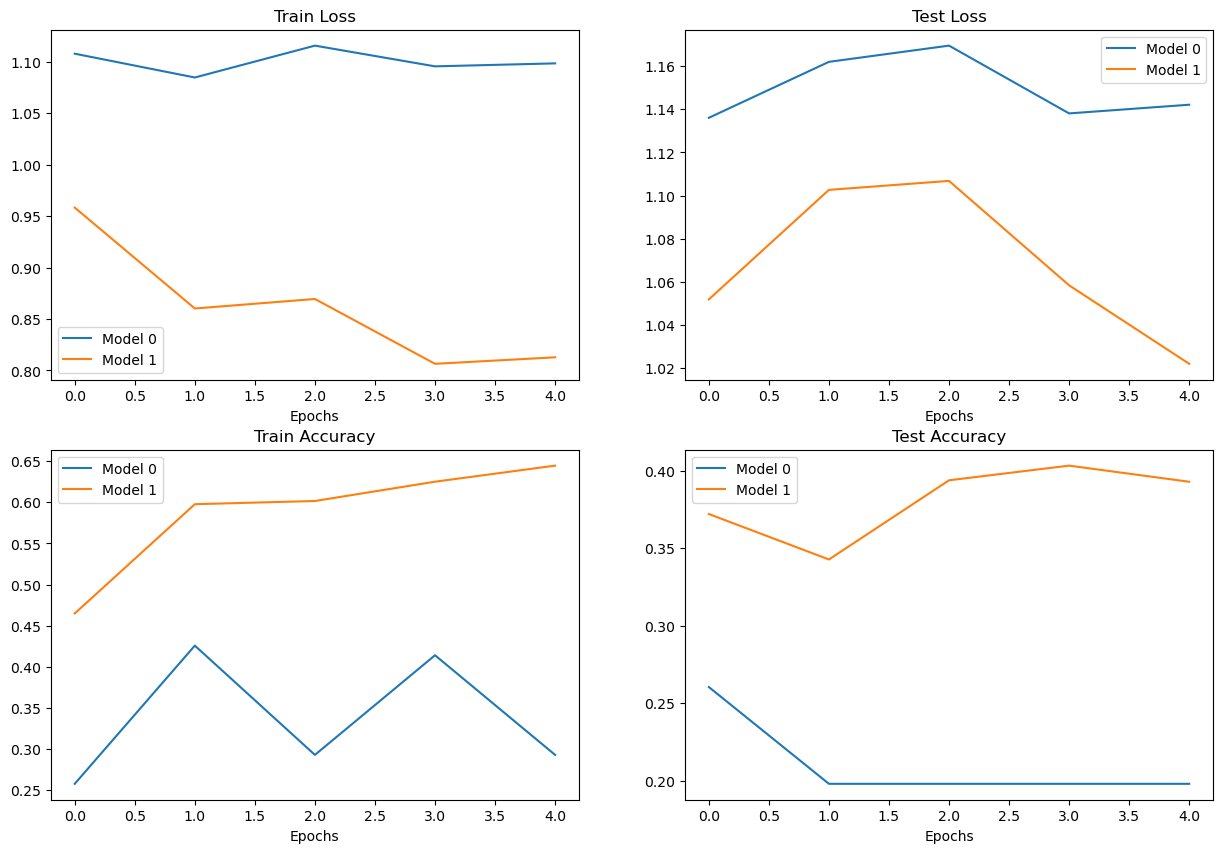

In [ ]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making Prediction on a custom Image

In [101]:
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image
with open(custom_image_path, 'wb') as f:
    request = requests.get('https://raw.github.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    f.write(request.content)

### 11.1 Loading in a custom image with Pytorch 

We have to make sure our custom image is in the same format as the data our model was trained on

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device


In [102]:
import torchvision

# Read in custom image
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
custom_image_unit8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

### 11.2 Making a Prediction on a Custom Image with a trained Pytorch Model


In [103]:
# Let's convert image & tensor to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them btw [0,1]
custom_image = custom_image / 255


(-0.5, 3023.5, 4031.5, -0.5)

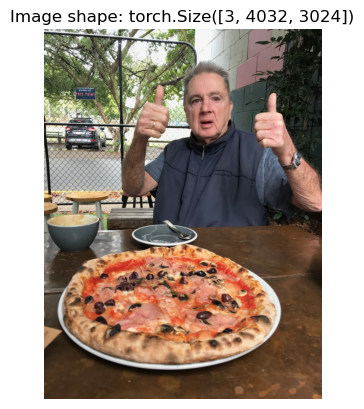

In [104]:
# Plot custom image
plt.imshow(custom_image.permute(1,2,0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [105]:
# Create transform pipline to resize image 
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

print(F"Original shape: {custom_image.shape}")
print(f"New shape:{custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape:torch.Size([3, 64, 64])


In [106]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes 
    print(f"Custom image transform shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transform shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])


In [107]:
custom_image_pred

tensor([[ 0.1161, -1.2045, -1.2651]], device='cuda:0')

In [108]:
# Convert logits -> prediction probs (use softmax for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)


In [117]:
import torch
import torchvision

In [122]:
def pred_and_plot_image(model: torch.nn.Module, image_path: str, class_names: List[str]=None, transform=None, device: torch.device=device):
    # Make a prediction on a target image and plots the image with its prediction
    # 1. load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them btw [0,1]
    target_image = target_image / 255
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode n inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to image
        target_image = target_image.unsqueeze(dim=0)
        
        # Make a prediction on image with an extra dimension and set it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction prob 
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    
    # 7. Convert prediction prob -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])


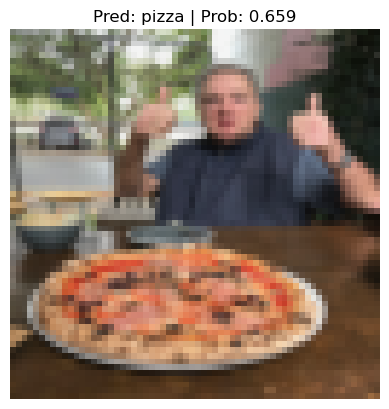

In [123]:
# Pred on our custom image
pred_and_plot_image(model=model_1, image_path=custom_image_path, class_names=class_names, transform=custom_image_transform, device=device)